<a href="https://colab.research.google.com/github/iamklacs97/Personal_Projects/blob/main/QSAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QSAR Modeling

## Estrogen receptor data

*Notebook by Kyle Lacson*

**Citation for dataset:** https://catalog.data.gov/dataset/in-vitro-and-in-vivo-estrogen-receptor-data-sets

**Citation for study:** https://www.tandfonline.com/doi/full/10.1080/1062936X.2015.1125945

**Reference for ER:** https://www.cancer.org/cancer/types/breast-cancer/understanding-a-breast-cancer-diagnosis/breast-cancer-hormone-receptor-status.html

## 1. Load modules and libraries

In [1]:
pip install rdkit # need to install rdkit each time google colab host is initialized

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 14.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## 2. Import data

In [3]:
# - changing working directory
path_dir = r'/content/drive/MyDrive'
os.chdir(path_dir)

In [4]:
# - import excel
estrogen_dict = pd.read_excel(os.path.join(os.getcwd(),'scihub data for ER paper.xlsx'), sheet_name = None)

In [5]:
estrogen_dict.keys()

dict_keys(['Summary', 'Dictionary', 'Binding', 'Agonist', 'Antagonist', 'CERAPP Chemical Data', 'Mouse In Vivo'])

In [6]:
# - Set each sheet from the excel as its own variable from the extracted dictionary
for i in estrogen_dict.keys():
  if 'Summary' == i:
    summary = estrogen_dict[i]
  elif 'Dictionary' == i:
    dictionary = estrogen_dict[i]
  elif 'Binding' == i:
    binding = estrogen_dict[i]
  elif 'Agonist' == i:
    agonist = estrogen_dict[i]
  elif 'Antagonist' == i:
    antagonist = estrogen_dict[i]
  elif 'CERAPP' in i:
    cerapp = estrogen_dict[i]
  elif 'In Vivo' in i:
    mouse = estrogen_dict[i]
  else:
    print(i)

**Notes:**

https://www.drugsandalcohol.ie/glossary/info/agonist

- Agonist: Agonist: A chemical substance that binds to and activates certain receptors on cells, causing a biological response. Oxycodone, morphine, heroin, fentanyl, methadone, and endorphins are all examples of opioid receptor agonists.
- Antagonist:  Antagonist: A chemical substance that binds to and blocks the activation of certain receptors on cells, preventing a biological response. Naloxone is an example of an opioid receptor antagonist

### 2.1 Viewing each sheet from the excel

In [7]:
summary

,Column1,Column2,Column3
0,Tab,Description,Reference
1,Binding,In vitro data for ER binding,"""Supplemental_Material_4_evaluationSet.xlsx"" i..."
2,Agonist,In vitro data for ER agonism,"""Supplemental_Material_4_evaluationSet.xlsx"" i..."
3,Antagonist,In vitro data for ER antagonism,"""Supplemental_Material_4_evaluationSet.xlsx"" i..."
4,CERAPP Chemical Data,Chemical information for in vitro data,"""Supplemental_Material_4_evaluationSet.xlsx"" i..."
5,Mouse In Vivo,In vivo data for mouse uterotrophic assay,"Shen et al, 2013"


**Notes:**

In vitro Data: Binding, Agonist, Antagonist, and CERAPP dataset
-> Should attempt to combine them into one dataset?

In vivo Data: Mouse

In [8]:
# - combine in vitro dataframes
antag_agon = pd.merge(left = antagonist, right = agonist, how = 'left', left_on = 'ID', right_on = 'ID', suffixes = ['_antagonist','_agonist'])
in_vitro = pd.merge(left = binding, right = antag_agon, how = 'left', left_on = 'ID', right_on = 'ID')

# - Adjusting column names to join datasets together
in_vitro.rename({'Class': 'Class_binding',
                  'Set': 'Set_binding'}, axis = 1, inplace = True)

In [9]:
# - cleaning up dataframes
in_vitro.drop(columns = ['Smiles_antagonist','Smiles_agonist'], inplace = True)

In [10]:
#  Dictionary to convert smiles to InChI code
smile_to_InChI = cerapp[['STANDARDIZED_CANO_SMI','InChI_Code']].set_index('STANDARDIZED_CANO_SMI').to_dict()['InChI_Code'] # use this dictionary turn target mode molecules into InChI

## 3. Pull in molecular descriptors fro each smiles

rdkit smiles: https://www.blopig.com/blog/2022/06/how-to-turn-a-molecule-into-a-vector-of-physicochemical-descriptors-using-rdkit/

In [11]:
### creating class
import time

class Molecules:

  smile_to_InChI = smile_to_InChI # internal dictionary: target molecules Smiles fomrate to InChI
  chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']

  def __init__(self, main_dataset: pd.DataFrame):
    self.data = main_dataset

  def add_InChI_column(self): # run first
    # create new InChI_Code column
    self.data['InChI_Code'] = self.data['Smiles'].apply(lambda x: smile_to_InChI[x])

    # resdistribute columns
    empty_columns = []
    data_columns = list(self.data.columns)
    empty_columns.append(data_columns[0])
    empty_columns.append(data_columns[-1])
    empty_columns = empty_columns + data_columns[1:-1]
    self.data = self.data[empty_columns] # updates self.data to new column format

    return self.data # do I need to return this value?

  def Inchi_to_descriptors(self): # run second
    start = time.time()
    # - empty list to hold descriptors for agonists molecules
    descriptors = []

    # - loops through InChI_Code column and inputs each inchi code to get the descriptors for each molecules
    for i in self.data['InChI_Code']:
      molecule = rdkit.Chem.inchi.MolFromInchi(i)
      descriptor_calc = MolecularDescriptorCalculator(Molecules.chosen_descriptors)
      descriptors.append(np.array(descriptor_calc.CalcDescriptors(molecule)))

    descriptor_vals = np.array(descriptors) # holds the list/array of the descriptor values
    descriptor_df = pd.DataFrame(data = descriptor_vals, columns = Molecules.chosen_descriptors) # model initialized values... should this be instance specific?

    # - combine data with descriptors
    self.data = pd.concat([self.data,descriptor_df], axis = 1)
    end = time.time()
    print(f'Total time to extract descriptors: {end - start} seconds') # time it took to execute method
    return self.data

### 3.1 Agonist Molecules

In [12]:
# - Initalize agonist molecule instance
agonist_molecule = Molecules(main_dataset = agonist)

In [13]:
# - Dataset conformation
agonist_molecule.add_InChI_column()
agonist_molecule.Inchi_to_descriptors()

[00:20:47] Cannot assign bond directions!
[00:20:56] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)

[00:21:06] Cannot assign bond directions!
[00:21:07] WARNING: not removing hydrogen atom without neighbors
[00:21:07] WARNING: not removing hydrogen atom without neighbors


Total time to extract descriptors: 87.45779418945312 seconds


,ID,InChI_Code,Smiles,Class,Set,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,C10001,InChI=1S/CH2O/c1-2/h1H2,C=O,1,T,2.000000,2.000000,2.000000,1.115355,1.115355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360624
1,C10002,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,0,T,1.837692,804.748825,20.698306,16.613088,16.613088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667213
2,C10003,InChI=1S/C23H32O6/c1-13(24)29-12-19(27)23(28)9...,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,0,T,1.654620,786.237565,21.189870,17.571026,17.571026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700523
3,C10004,InChI=1S/C23H30O6/c1-13(24)29-12-19(27)23(28)9...,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,0,T,1.664596,827.224695,21.189870,17.454710,17.454710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.728839
4,C10005,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,"CCC1(c2ccccc2)C(=O)NC(=O)NC1=O, CCC1(c2ccccc2)...",0,T,2.626472,483.741843,12.466255,9.290961,9.290961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.820718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6314,C59862,InChI=1S/C20H18O3/c21-13-16-3-1-2-4-19(16)20(1...,OCc1ccccc1C(c1ccc(O)cc1)c1ccc(O)cc1,1,T,2.166816,731.241981,16.233840,12.554301,12.554301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.643024
6315,C61094,InChI=1S/C16H12O5/c1-20-11-4-2-9(3-5-11)14-8-1...,COc1ccc(cc1)C1=CC(=O)c2c(cc(O)cc2O)O1,1,T,2.216695,862.209998,14.982763,11.160624,11.160624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756010
6316,C61640,InChI=1S/C28H18O4/c29-25-15-13-23(17-7-1-3-9-1...,Oc1ccc(c2ccccc12)C1(OC(=O)c2ccccc12)c1ccc(O)c2...,1,T,1.821185,1465.277128,21.871668,16.948528,16.948528,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352156
6317,C62669,InChI=1S/C12H16O3/c1-2-3-4-5-11(14)10-7-6-9(13...,CCCCCC(=O)c1ccc(O)cc1O,1,T,2.653054,344.720510,11.259149,8.863153,8.863153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.577486


In [14]:
# Initialization of agonist dataset
agonist_dataset = agonist_molecule.data

# Keep this commented out

In [15]:
# # - Create new column of InChI_Code given smiles format
# agonist['InChI_Code'] = agonist.Smiles.apply(lambda x: smile_to_InChI[x])

In [16]:
# # - Fixing agonist columns layout
# '''
# Function: Change order columns within agonist dataset
# '''
# def agonist_columns():
#     col_list = []
#     ag_cols = list(agonist.columns)
#     col_list.append(ag_cols[0])
#     col_list.append(ag_cols[-1])
#     col_list = col_list + ag_cols[1:-1]
#     return agonist[col_list]

# # - Initialize agonist columns
# agonist = agonist_columns()

In [17]:
# # - Function to extract descriptors for each molecule

# # - molecular descriptors
# chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']

# '''
# Function: Purpose of this function is to take each InChi Code from the dataset and to create an array of the descriptors to add after
# '''
# def Inchi_to_descriptors(InChI_dataset: pd.Series) -> np.array:

#   # - empty list to hold descriptors for agonists molecules
#   agonist_descriptors = []

#   for i in InChI_dataset:
#     molecule = rdkit.Chem.inchi.MolFromInchi(i)
#     descriptor_calc = MolecularDescriptorCalculator(chosen_descriptors)
#     agonist_descriptors.append(np.array(descriptor_calc.CalcDescriptors(molecule)))

#   return np.array(agonist_descriptors)

In [18]:
# # - Initialize agonist descriptors function
# %%time
# agonist_descriptors = Inchi_to_descriptors(agonist.InChI_Code)

In [19]:
# # - Create new dataframe of agonist descriptors
# agonist_descriptors = pd.DataFrame(data = agonist_descriptors, columns = chosen_descriptors)
# agonist_descriptors

In [20]:
## - Join agonist and descriptor dataframes
# agonist_dataset = pd.concat([agonist, agonist_descriptors], axis = 1) # dataset that encompasses desriptors with InChI codes/smiles

# Keep everything below

In [21]:
# - Look for null values
agonist_dataset.isnull().sum().sort_values(ascending = False) # address na values

MinPartialCharge       10
MinAbsPartialCharge    10
MaxPartialCharge       10
MaxAbsPartialCharge    10
ID                      0
                       ..
PEOE_VSA12              0
PEOE_VSA13              0
PEOE_VSA14              0
PEOE_VSA2               0
qed                     0
Length: 205, dtype: int64

**Note:** Need to address na values found

In [22]:
# - Rows with n/a values
[ix for ix,i in enumerate(agonist_dataset.isnull().any(axis = 1)) if i == True] # rows with nulls

[392, 915, 947, 955, 1559, 1566, 2605, 3053, 3639, 5217]

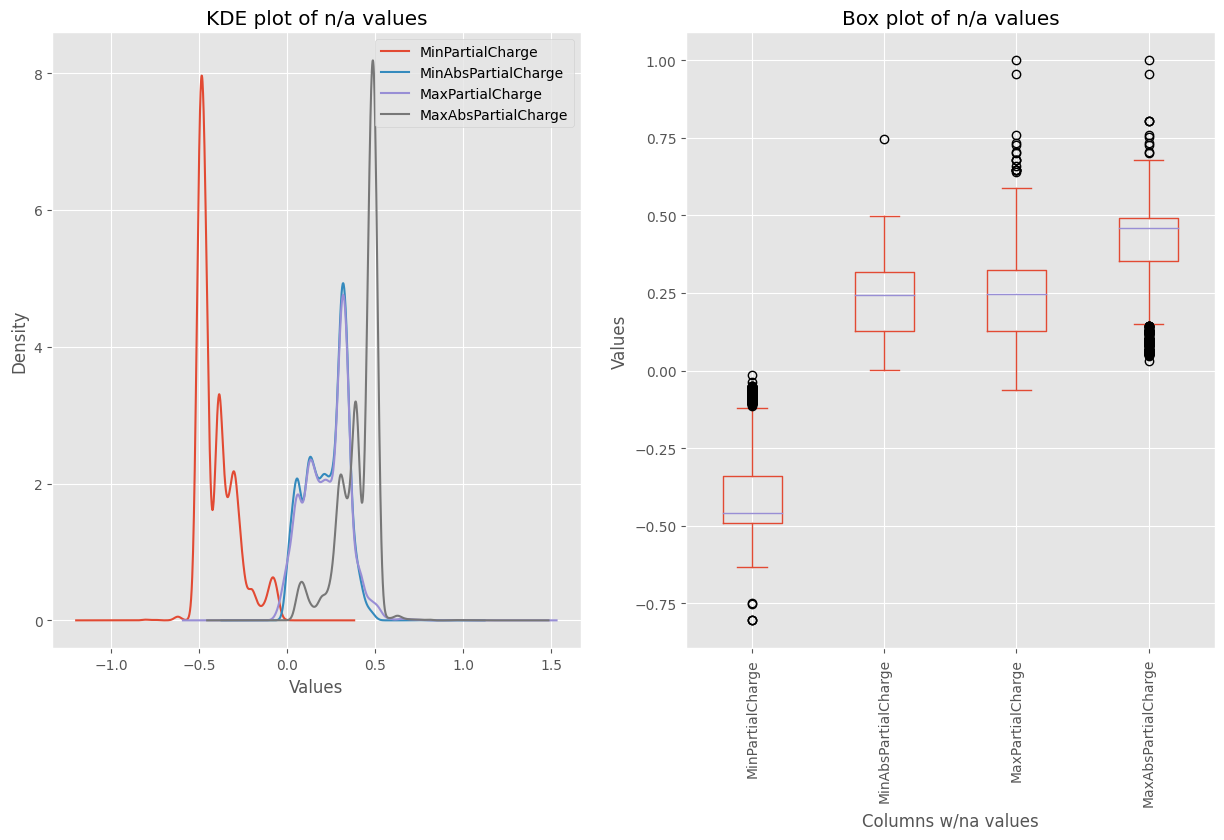

In [23]:
# - Visualize missing data
'''
Function: Visualize rows with na values
'''
def visualize_na():
  fig, ax = plt.subplots(1,2, figsize = (15,8))
  agonist_dataset[agonist_dataset.isnull().sum().sort_values(ascending = False)[:4].index].plot(kind = 'kde', ax = ax[0])
  ax[0].set_xlabel('Values')
  ax[0].set_title('KDE plot of n/a values')
  ax[0].legend(loc = 'upper right')

  agonist_dataset[agonist_dataset.isnull().sum().sort_values(ascending = False)[:4].index].plot(kind = 'box', ax = ax[1])
  ax[1].set_xlabel('Columns w/na values')
  ax[1].set_ylabel('Values')
  ax[1].set_title('Box plot of n/a values')
  ax[1].set_xticklabels(rotation = 90, labels = agonist_dataset.isnull().sum().sort_values(ascending = False)[:4].index)
  plt.show()

visualize_na()


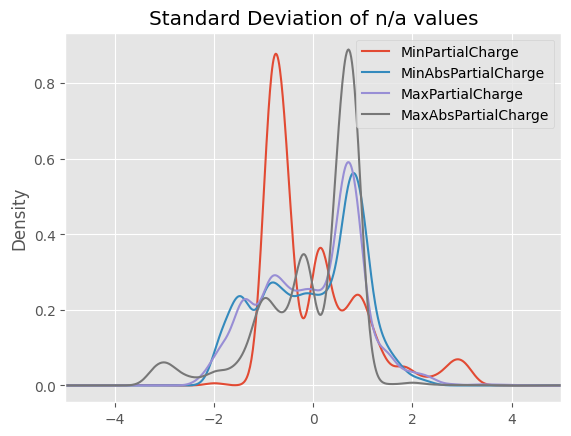

In [24]:
# - Look at statistics for columns with n/a values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standard_na = pd.DataFrame(data = scaler.fit_transform(agonist_dataset[agonist_dataset.isnull().sum().sort_values(ascending = False)[:4].index]), columns = list(agonist_dataset[agonist_dataset.isnull().sum().sort_values(ascending = False)[:4].index]))
standard_na.plot(kind = 'kde')
plt.title('Standard Deviation of n/a values')
plt.xlim(-5,5);

**Notes:**

Distribution is very spreadout, does not follow a normal curve... KNN can be used to fill in the missing values

A lot of skewed values

In [25]:
# - Use KNN to fill out values
from sklearn.impute import KNNImputer

na_df = pd.DataFrame(data = scaler.inverse_transform(standard_na), columns = standard_na.columns)
na_df # dataframes

'''
Function: Use of KNN algorithm to predict null values
'''
def knn_na_values(df: pd.DataFrame):
  imputer = KNNImputer()
  fixed_df = pd.DataFrame(data = imputer.fit_transform(df), columns = df.columns)
  return fixed_df

In [26]:
# - Initialize new dataframe
agonist_knn_na = knn_na_values(na_df)

In [27]:
# - Check for null values
agonist_knn_na.isnull().sum()

MinPartialCharge       0
MinAbsPartialCharge    0
MaxPartialCharge       0
MaxAbsPartialCharge    0
dtype: int64

In [28]:
# - Update agonist dataset with imputed values
agonist_dataset[agonist_knn_na.columns] = agonist_knn_na
agonist_dataset.isnull().sum().sort_values(ascending = False) ### === agonist_dataset

ID            0
fr_SH         0
fr_C_S        0
fr_HOCCN      0
fr_Imine      0
             ..
PEOE_VSA1     0
PEOE_VSA10    0
PEOE_VSA11    0
PEOE_VSA12    0
qed           0
Length: 205, dtype: int64

### 3.2 Antagonist Molecules

In [29]:
# - Initialize antagonist molecules
antagonist_molecule = Molecules(main_dataset = antagonist)

In [30]:
# - Molecule methods to create dataframe
antagonist_molecule.add_InChI_column()
antagonist_molecule.Inchi_to_descriptors()

[00:22:07] Cannot assign bond directions!
[00:22:26] Cannot assign bond directions!
[00:22:27] WARNING: not removing hydrogen atom without neighbors
[00:22:27] WARNING: not removing hydrogen atom without neighbors


Total time to extract descriptors: 73.82040429115295 seconds


,ID,InChI_Code,Smiles,Class,Set,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,C10002,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,0,T,1.837692,804.748825,20.698306,16.613088,16.613088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667213
1,C10003,InChI=1S/C23H32O6/c1-13(24)29-12-19(27)23(28)9...,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,0,T,1.654620,786.237565,21.189870,17.571026,17.571026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700523
2,C10004,InChI=1S/C23H30O6/c1-13(24)29-12-19(27)23(28)9...,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,0,T,1.664596,827.224695,21.189870,17.454710,17.454710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.728839
3,C10005,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,"CCC1(c2ccccc2)C(=O)NC(=O)NC1=O, CCC1(c2ccccc2)...",0,T,2.626472,483.741843,12.466255,9.290961,9.290961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.820718
4,C10006,InChI=1S/C15H18N4O5/c1-5-9(16)12(21)8-6(4-24-1...,CC1C(=N)C(=O)C2C(COC(N)=O)C3(OC)C4NC4CN3C=2C1=O,1,T,1.852935,731.376056,17.386387,13.251035,13.251035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,C29412,InChI=1S/C25H30O4/c1-20(12-8-14-22(3)16-18-24(...,COC(=O)C=CC(C)=CC=CC(C)=CC=CC=C(C)C=CC=C(C)C=C...,0,T,4.669806,822.884666,22.070703,17.754862,17.754862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288431
6535,C47836,InChI=1S/C29H39NO3/c1-28-18-25(19-5-8-21(9-6-1...,CC12CC(C3C(CCC4=CC(=O)CCC4=3)C1CCC2(O)CCCO)c1c...,0,T,1.624648,990.624284,23.380104,20.439759,20.439759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652180
6536,C49687,InChI=1S/C28H31NO2/c30-24-11-15-27-23(20-24)10...,Oc1cc2CCC(C(c2cc1)c1ccc(cc1)OCCN1CCCC1)c1ccccc1,1,T,1.383458,993.280861,21.045395,18.042433,18.042433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560212
6537,C49730,InChI=1S/C19H26N6O/c1-4-15(11-26)22-19-23-17(2...,CC(C)[n]1c[n]c2c1[n]c(NC(CO)CC)[n]c2NCc1ccccc1,1,P,2.043834,908.674087,18.518297,15.476190,15.476190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.608167


In [31]:
# - Init dataset
antagonist_dataset = antagonist_molecule.data

In [32]:
# - n/a values in antagonist dataset
antagonist_dataset.isnull().sum().sort_values(ascending = False)

MinPartialCharge       10
MinAbsPartialCharge    10
MaxPartialCharge       10
MaxAbsPartialCharge    10
ID                      0
                       ..
PEOE_VSA12              0
PEOE_VSA13              0
PEOE_VSA14              0
PEOE_VSA2               0
qed                     0
Length: 205, dtype: int64

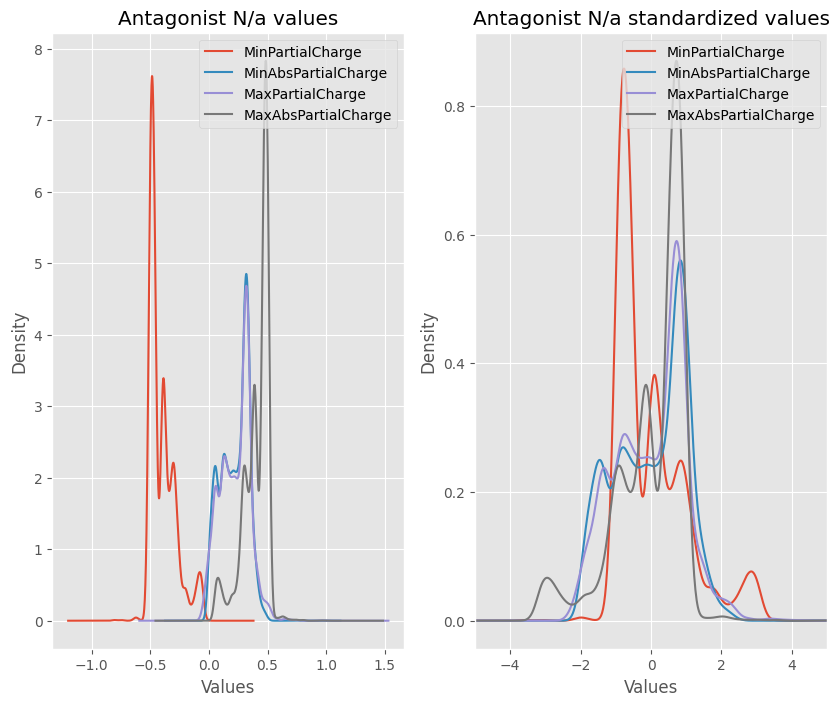

In [33]:
# - Antagonist na columns
from sklearn.preprocessing import StandardScaler
'''
Function: Visualize antagonist dataset columns with null values
'''
def visualize_distribution():
  ant_na_df = antagonist_dataset[antagonist_dataset.isnull().sum().sort_values(ascending = False).index[:4]] # na value dataset

  # standard na dataset
  fig, ax = plt.subplots(1,2, figsize = (10,8))
  ant_na_df.plot(kind = 'kde', ax = ax[0])
  ax[0].set_title('Antagonist N/a values')
  ax[0].set_xlabel('Values')

  # scaled na dataset
  scaler = StandardScaler()
  pd.DataFrame(data = scaler.fit_transform(ant_na_df), columns = ant_na_df.columns).plot(kind = 'kde', ax = ax[1])
  ax[1].set_title('Antagonist N/a standardized values')
  ax[1].set_xlabel('Values')
  ax[1].set_xlim(-5.0,5.0)
  plt.show()

  return ant_na_df

na_df = visualize_distribution()

**Note:** Because there are only 10 rows with missing columns, we can also use a method to input missing values.

In [34]:
# - kNN Imputer for missing values
antagonist_na_values = knn_na_values(na_df)

# - Update antagonist dataset
antagonist_dataset[antagonist_na_values.columns] = antagonist_na_values ##### main antagonist dataset

### 3.3 Binding Molecules

In [35]:
# Initialize binding molecule instance
binding_molecule = Molecules(binding)

In [36]:
# Compose binding dataset
binding_molecule.add_InChI_column()
binding_molecule.Inchi_to_descriptors()

[00:23:24] Cannot assign bond directions!
[00:23:34] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)

[00:23:45] Cannot assign bond directions!
[00:23:46] WARNING: not removing hydrogen atom without neighbors
[00:23:46] WARNING: not removing hydrogen atom without neighbors


Total time to extract descriptors: 87.50385069847107 seconds


,ID,InChI_Code,Smiles,Class,Set,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,C10001,InChI=1S/CH2O/c1-2/h1H2,C=O,1,T,2.000000,2.000000,2.000000,1.115355,1.115355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360624
1,C10003,InChI=1S/C23H32O6/c1-13(24)29-12-19(27)23(28)9...,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,0,T,1.654620,786.237565,21.189870,17.571026,17.571026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700523
2,C10004,InChI=1S/C23H30O6/c1-13(24)29-12-19(27)23(28)9...,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,0,T,1.664596,827.224695,21.189870,17.454710,17.454710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.728839
3,C10005,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,"CCC1(c2ccccc2)C(=O)NC(=O)NC1=O, CCC1(c2ccccc2)...",0,T,2.626472,483.741843,12.466255,9.290961,9.290961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.820718
4,C10006,InChI=1S/C15H18N4O5/c1-5-9(16)12(21)8-6(4-24-1...,CC1C(=N)C(=O)C2C(COC(N)=O)C3(OC)C4NC4CN3C=2C1=O,1,T,1.852935,731.376056,17.386387,13.251035,13.251035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278,C62566,InChI=1S/C10H12O4/c1-3-14-10(13)9-6(2)4-7(11)5...,Cc1cc(O)cc(O)c1C(=O)OCC,1,P,3.139090,334.134785,10.715178,8.072731,8.072731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.704580
7279,C62641,InChI=1S/C16H12O5/c1-20-11-6-12(18)16-13(19)8-...,COc1cc(O)c2c(c1)OC(=CC2=O)c1ccc(O)cc1,1,T,2.266994,862.209998,14.982763,11.160624,11.160624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756010
7280,C62669,InChI=1S/C12H16O3/c1-2-3-4-5-11(14)10-7-6-9(13...,CCCCCC(=O)c1ccc(O)cc1O,1,T,2.653054,344.720510,11.259149,8.863153,8.863153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.577486
7281,C62726,InChI=1S/C18H22O2/c1-18-9-8-14-13-5-3-12(19)10...,CC12CCC3c4ccc(O)cc4CC=C3C1CCC2O,1,T,1.756095,589.081061,13.905413,11.971413,11.971413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.708011


In [37]:
# - Init modified binding dataset from instance
binding_dataset = binding_molecule.data

In [38]:
# - Missing/na values in dataset
binding_dataset.isnull().sum().sort_values(ascending = False)

MinPartialCharge       11
MinAbsPartialCharge    11
MaxPartialCharge       11
MaxAbsPartialCharge    11
ID                      0
                       ..
PEOE_VSA12              0
PEOE_VSA13              0
PEOE_VSA14              0
PEOE_VSA2               0
qed                     0
Length: 205, dtype: int64

In [39]:
# - Visualize standard and scaled dataset
'''
Function: Takes the columns with missing/na values and creates a dataframe. This dataframe is then visualized pre and post standardization.
'''

def visualize_distribution():
  bind_na_df = binding_dataset[binding_dataset.isnull().sum().sort_values(ascending = False).index[:4]] # na value dataset

  # standard na dataset
  fig, ax = plt.subplots(1,2, figsize = (10,8))
  bind_na_df.plot(kind = 'kde', ax = ax[0])
  ax[0].set_title('Binding Molecules N/a values')
  ax[0].set_xlabel('Values')

  # scaled na dataset
  scaler = StandardScaler()
  pd.DataFrame(data = scaler.fit_transform(bind_na_df), columns = bind_na_df.columns).plot(kind = 'kde', ax = ax[1])
  ax[1].set_title('Binding Molecules N/a standardized values')
  ax[1].set_xlabel('Values')
  ax[1].set_xlim(-5.0,5.0)
  plt.show()

  return bind_na_df

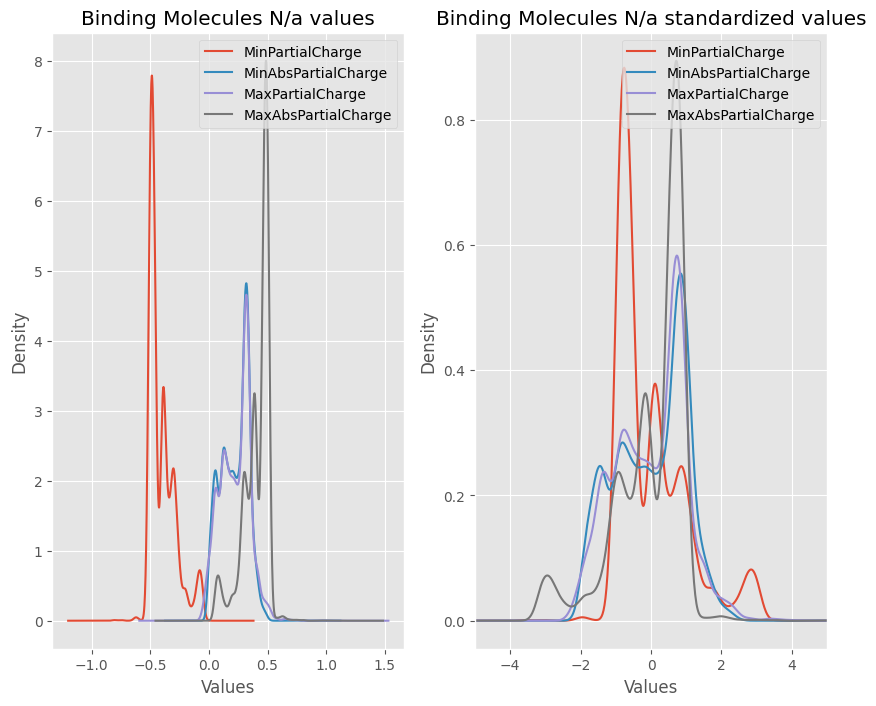

In [40]:
binding_na = visualize_distribution()

**Note:** 11 rows out of 7k rows are missing, can either remove or impute these variables.

In [41]:
# - kNN Imputer for missing values and updating binding dataset
binding_dataset[binding_na.columns] = knn_na_values(binding_na)

In [42]:
# - Checking for null or missing values
binding_dataset.isnull().sum().sort_values(ascending = False)

ID            0
fr_SH         0
fr_C_S        0
fr_HOCCN      0
fr_Imine      0
             ..
PEOE_VSA1     0
PEOE_VSA10    0
PEOE_VSA11    0
PEOE_VSA12    0
qed           0
Length: 205, dtype: int64

## 4. Model Training

### 4.1 Using the standard (no dimensional reduction) dataset

In [328]:
# - Train models class
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
class ClassificationModels:

  '''
  =====> Order of methods <=====
  1. Initialize ClassificationModels instance
  2. train_val_split()
  3. apply_scale()
  4. apply_pca()
  5. model()
  6. evaluate_testset()
  '''

  def __init__(self, dataset: pd.DataFrame):
    self.data = dataset

  def train_val_split(self):
    X = self.data.drop(columns = ['ID','InChI_Code','Smiles','Class'])
    y = self.data[['Class','Set']]

    # training set provided by research experiment protocol denoted by 'T'
    self.train_features = X[X['Set'] == 'T'].drop(columns = 'Set')
    self.train_predictors = y[y['Set'] == 'T'].drop(columns = 'Set')

    # test set provided by research experiment protocol denoted by 'P'
    self.test_features = X[X['Set'] == 'P'].drop(columns = 'Set')
    self.test_predictors = y[y['Set'] == 'P'].drop(columns = 'Set')

    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.train_features, self.train_predictors, test_size = 0.2, random_state = 42)

  def apply_scale(self):
    # scaling train features than transforming validation and test features
    scaler = StandardScaler()
    scaler.fit(self.X_train)
    self.X_train_sc = pd.DataFrame(data = scaler.transform(self.X_train), columns = self.X_train.columns)

    # transform validation features using initialized scaler method
    self.X_val_sc = pd.DataFrame(data = scaler.transform(self.X_val), columns = self.X_val.columns)

    # # transform test features using initialized scaler method
    self.test_features_sc = pd.DataFrame(data = scaler.transform(self.test_features), columns = self.test_features.columns)

  def apply_pca(self, percent_of_variance: int = 0.95):
    pca = PCA(percent_of_variance, random_state = 42)
    pca.fit(self.X_train_sc)

    # train pca
    self.X_train_pca = pd.DataFrame(data = pca.transform(self.X_train_sc))

    # validation pca
    self.X_val_pca = pd.DataFrame(data = pca.transform(self.X_val_sc))

    # test pca
    self.test_features_pca = pd.DataFrame(data = pca.transform(self.test_features_sc))

  def model(self, classifier: str = None, with_pca: bool = False):

    if classifier == None:
      raise Exception('Please select a classifier.')
    else:
      print(f'Classifier used: {classifier}')

    if classifier == 'Logistic Regression':
      self.clf = LogisticRegression(random_state = 42, n_jobs = -1)
    elif classifier == 'KNN':
      self.clf = KNeighborsClassifier(n_jobs = -1)
    elif classifier == 'SVM':
      self.clf = SVC(random_state = 42)
    elif classifier == 'LDA':
      self.clf = LinearDiscriminantAnalysis()
    elif classifier == 'QDA':
      self.clf = QuadraticDiscriminantAnalysis()
    else:
      raise Exception('Please choose, select, and insert in the classifier of your choice. Be sure to correctly spell the classifier.')

    if with_pca: # with PCA dataset

      try:
        # self.clf = classifier
        self.clf.fit(self.X_train_pca, self.y_train)
        y_pred = self.clf.predict(self.X_val_pca)
        y_pred_prob = self.clf.predict_proba(self.X_val_pca)

        accuracy = accuracy_score(self.y_val, y_pred)
        roc_score = roc_auc_score(self.y_val, y_pred_prob[:,1])

        cm = confusion_matrix(self.y_val, y_pred, labels = self.clf.classes_)
        disp = ConfusionMatrixDisplay(cm, display_labels = self.clf.classes_)

        disp.plot()
        plt.show()

        print(classification_report(self.y_val, y_pred))
        print(f'Classifier: {classifier} w/PCA dataset\n')
        print(f'Accuracy_Score: {accuracy}\nROC-AUC Score: {roc_score}\n','-'*100)

      except:
        print('Something went wrong during the model training and execution with the PCA derived dataset. Try again.')

    else: # w/out PCA dataset
      try:
        # self.clf = classifier
        self.clf.fit(self.X_train_sc, self.y_train)
        y_pred = self.clf.predict(self.X_val_sc)
        y_pred_prob = self.clf.predict_proba(self.X_val_sc)

        accuracy = accuracy_score(self.y_val, y_pred)
        roc_score = roc_auc_score(self.y_val, y_pred_prob[:,1])

        cm = confusion_matrix(self.y_val, y_pred, labels = self.clf.classes_)
        disp = ConfusionMatrixDisplay(cm, display_labels = self.clf.classes_)

        disp.plot()
        plt.show()

        print(classification_report(self.y_val, y_pred))
        print(f'Classifier: {classifier}\n')
        print(f'Accuracy_Score: {accuracy}\nROC-AUC Score: {roc_score}\n','-'*100)

      except:
        print('Something went wrong during the model training and execution with the standardized dataset. Try again.')

    return self.clf # return the classifier to use and tune

  def evaluate_testset(self, clf):

    y_pred = clf.predict(self.test_features_sc)
    accuracy = accuracy_score(self.test_predictors, y_pred)

    cm = confusion_matrix(self.test_predictors, y_pred, labels = clf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels =clf.classes_)

    print(f'Test Set Evaluation   |   Classifier: {clf}')
    disp.plot()
    plt.show()

    print(classification_report(self.test_predictors, y_pred))
    print(f'Classifier: {clf}\n')
    print(f'Accuracy_Score: {accuracy}\n','-'*100)


In [329]:
# - Init agonist classifcation model instance
agonist_classification = ClassificationModels(dataset = agonist_dataset)

In [330]:
# - splitting data
agonist_classification.train_val_split()
agonist_classification.apply_scale()
agonist_classification.apply_pca(percent_of_variance = 0.8) # maybe try percent_of_variance = 0.90?

Classifier used: Logistic Regression


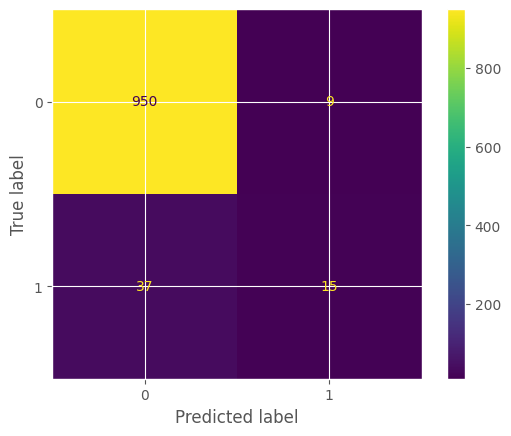

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       959
           1       0.62      0.29      0.39        52

    accuracy                           0.95      1011
   macro avg       0.79      0.64      0.69      1011
weighted avg       0.95      0.95      0.95      1011

Classifier: Logistic Regression

Accuracy_Score: 0.9545004945598418
ROC-AUC Score: 0.7770915216170691
 ----------------------------------------------------------------------------------------------------


In [331]:
# - apply model
clf = agonist_classification.model(classifier = 'Logistic Regression')

Classifier used: Logistic Regression


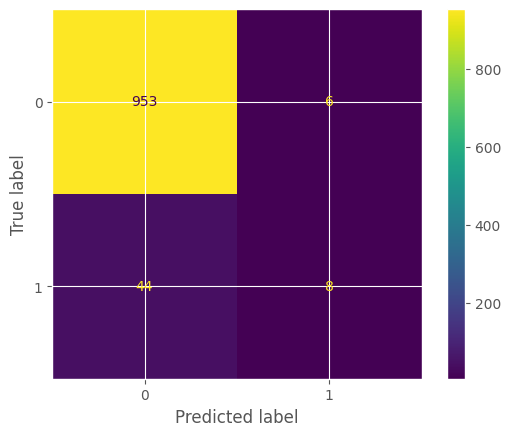

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       959
           1       0.57      0.15      0.24        52

    accuracy                           0.95      1011
   macro avg       0.76      0.57      0.61      1011
weighted avg       0.94      0.95      0.94      1011

Classifier: Logistic Regression w/PCA dataset

Accuracy_Score: 0.950544015825915
ROC-AUC Score: 0.784230368171974
 ----------------------------------------------------------------------------------------------------


LogisticRegression(n_jobs=-1, random_state=42)

In [332]:
# - apply model with pca
agonist_classification.model(classifier = 'Logistic Regression', with_pca = True)

Test Set Evaluation   |   Classifier: LogisticRegression(n_jobs=-1, random_state=42)


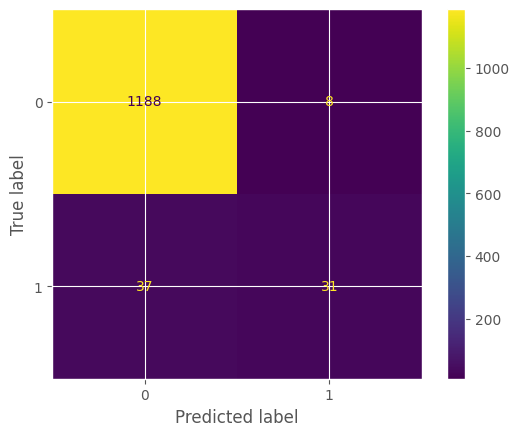

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1196
           1       0.79      0.46      0.58        68

    accuracy                           0.96      1264
   macro avg       0.88      0.72      0.78      1264
weighted avg       0.96      0.96      0.96      1264

Classifier: LogisticRegression(n_jobs=-1, random_state=42)

Accuracy_Score: 0.9643987341772152
 ----------------------------------------------------------------------------------------------------


In [333]:
agonist_classification.evaluate_testset(clf = clf)

Note to self: Need to add an evaluation function on the dataset...

Add tracking capabilities

*Note:*

1. Test LDA and QDA dataset transformation outside of the train model function? Unsure what the transformation enable/provide

2. Other dimension reducation techniques?

3. Address any class imbalances?
